## Introduction

**From the perspective of traffic safety, it is crucial to classify traffic signals. Drivers' disregard for the posted speed limit contributes significantly to traffic infractions on the road. In order to identify a speed limit sign in the image, several automakers employ traffic sign classification algorithms. These systems assess the vehicle's current speed against the maximum speed permitted for the present stretch of road and either alert the driver to excessive speed or automatically reduce it.**

**The driver will be alerted to the potential presence of the sign when traffic sign classification systems are used in conjunction with navigation systems, making it feasible to acquire information on the speed limit even when the sign has not been identified.**

**The categorization of traffic indicators in actual situations is the key issue with this endeavor. The process of classifying signs on a picture is significantly complicated by nighttime and unfavorable weather.**

## About the dataset

**The dataset can be obtained from https://www.kaggle.com/datasets/valentynsichkar/traffic-signs-preprocessed?datasetId=327959&sortBy=voteCount&select=data2.pickle**

Shapes of data2 are as following (RGB):

- xtrain: (86989, 3, 32, 32)
- ytrain: (86989,)

- xvalidation: (4410, 3, 32, 32)
- yvalidation: (4410,)

- xtest: (12630, 3, 32, 32)
- ytest: (12630,)

**mean image and standard deviation were calculated from train dataset and applied to validation and testing datasets for appropriate datasets. When using user's image for classification, it has to be preprocessed firstly in the same way and in the same order according to the chosen dataset among nine.**

**Some example of traffic signs are like:**

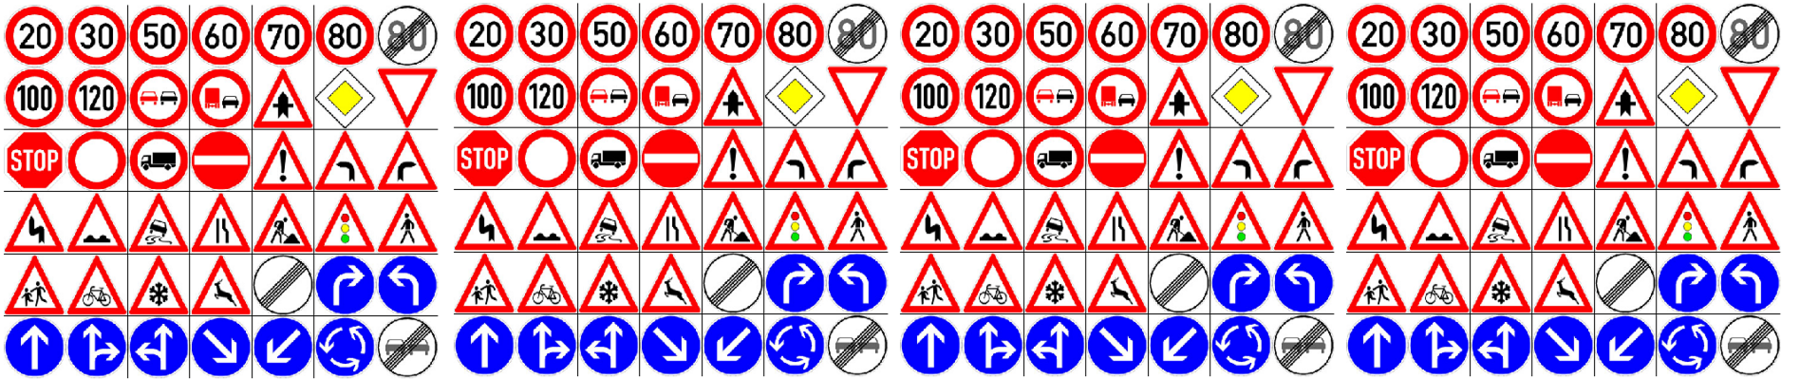

### Load dataset and libraries

In [30]:
import numpy as np 
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from keras.utils.np_utils import to_categorical
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler


In [31]:
import os as os

In [32]:
os.getcwd()

'C:\\Users\\shoud\\Jupyter documents\\IBM ML professional certification\\Deep learning and reinforcement learning\\Final project'

In [33]:
path='C:\\Users\\shoud\\Jupyter documents\\IBM ML professional certification\\Deep learning and reinforcement learning\\Final project'
os.chdir( path )

In [34]:
with open('data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1') 

In [35]:
data.items()

dict_items([('y_test', array([25, 11, 38, ...,  8, 33, 10], dtype=uint8)), ('y_validation', array([ 9, 37, 31, ...,  5, 18,  6], dtype=uint8)), ('x_validation', array([[[[-8.13200548e-02, -1.05785601e-01, -1.35571063e-01, ...,
          -1.33438379e-01, -1.00064300e-01, -8.01314786e-02],
         [-1.00652181e-01, -1.28710032e-01, -1.57822788e-01, ...,
          -1.62547588e-01, -1.36362046e-01, -1.08473681e-01],
         [-1.25605583e-01, -1.61946893e-01, -1.91582799e-01, ...,
          -1.84833080e-01, -1.58809453e-01, -1.29200697e-01],
         ...,
         [-8.20988938e-02, -1.09976135e-01, -1.44535631e-01, ...,
          -1.41712368e-01, -6.55412525e-02,  6.91929460e-03],
         [-6.42771199e-02, -8.87806639e-02, -1.19311996e-01, ...,
          -1.14659391e-01, -1.05807483e-02,  7.35892355e-02],
         [-4.32938561e-02, -6.82745054e-02, -8.79732892e-02, ...,
          -7.85297081e-02,  5.03404289e-02,  1.38326406e-01]],

        [[-8.57955888e-02, -1.09240018e-01, -1.37785345

In [36]:
# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)
#data['y_test']=to_categorical(data['y_test'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)


y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


In [8]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


In [9]:
# Visualizing some examples of training data
examples = data['x_train'][:81, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

(81, 32, 32, 3)


In [10]:
convert_to_grid(examples).shape

(296, 296, 3)

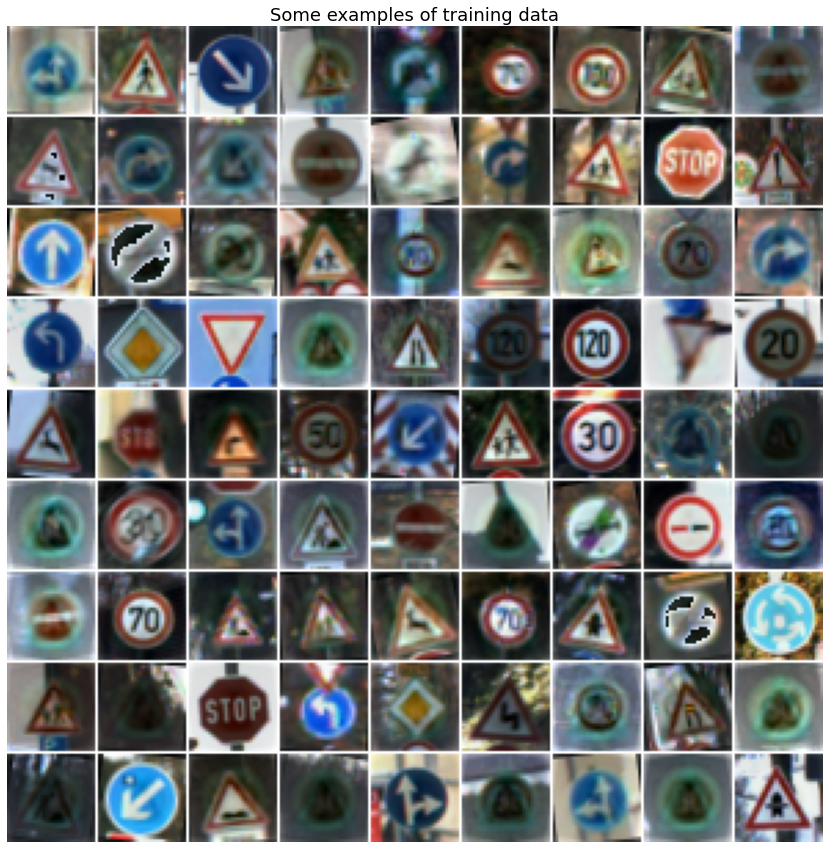

In [11]:
# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()

## Training Model

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 15

h = model.fit(data['x_train'][:10], data['y_train'][:10],
              batch_size=5, epochs = epochs,
              validation_data = (data['x_validation'], data['y_validation']),
              callbacks=[annealer], verbose=1)

Epoch 1/15
2/2 [==============================] - 5s 4s/step - loss: 3.8362 - accuracy: 0.0000e+00 - val_loss: 3.8074 - val_accuracy: 0.0408 - lr: 4.6329e-04
Epoch 2/15
2/2 [==============================] - 4s 4s/step - loss: 2.9545 - accuracy: 0.3000 - val_loss: 4.0528 - val_accuracy: 0.0476 - lr: 4.4013e-04
Epoch 3/15
2/2 [==============================] - 4s 4s/step - loss: 2.3790 - accuracy: 0.5000 - val_loss: 4.4885 - val_accuracy: 0.0456 - lr: 4.1812e-04
Epoch 4/15
2/2 [==============================] - 4s 4s/step - loss: 1.8961 - accuracy: 0.6000 - val_loss: 5.0006 - val_accuracy: 0.0424 - lr: 3.9721e-04
Epoch 5/15
2/2 [==============================] - 4s 4s/step - loss: 1.5914 - accuracy: 0.6000 - val_loss: 5.5281 - val_accuracy: 0.0397 - lr: 3.7735e-04
Epoch 6/15
2/2 [==============================] - 4s 4s/step - loss: 1.3336 - accuracy: 0.7000 - val_loss: 6.0298 - val_accuracy: 0.0392 - lr: 3.5849e-04
Epoch 7/15
2/2 [==============================] - 4s 4s/step - loss: 1.1

In [16]:
print('Epochs={0:d}, training accuracy={1:.5f}, validation accuracy={2:.5f}'.\
      format(epochs, max(h.history['accuracy']), max(h.history['val_accuracy'])))

Epochs=15, training accuracy=1.00000, validation accuracy=0.04762


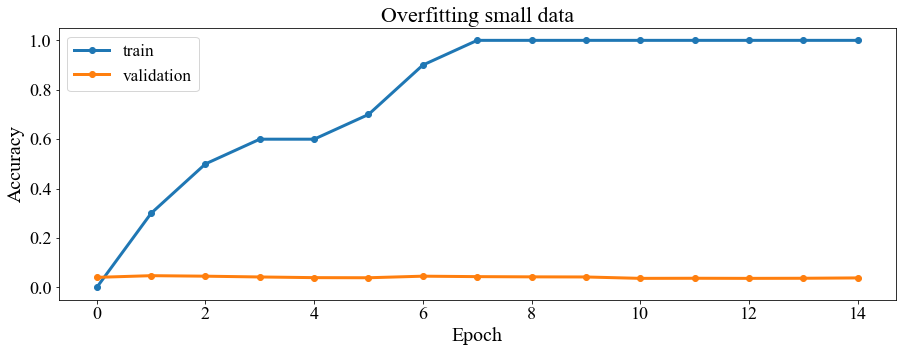

In [17]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['font.family'] = 'Times New Roman'

fig = plt.figure()
plt.plot(h.history['accuracy'], '-o', linewidth=3.0)
plt.plot(h.history['val_accuracy'], '-o', linewidth=3.0)
plt.title('Overfitting small data', fontsize=22)
plt.legend(['train', 'validation'], loc='upper left', fontsize='xx-large')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('overfitting_small_data.png')
plt.close()

In [18]:
filters = [3, 5, 9, 13, 15, 19, 23, 25, 31]
model = [0] * len(filters)

for i in range(len(model)):
    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size=filters[i], padding='same', activation='relu', input_shape=(32, 32, 3)))
    model[i].add(MaxPool2D(pool_size=2))
    model[i].add(Flatten())
    model[i].add(Dense(500, activation='relu'))
    model[i].add(Dense(43, activation='softmax'))
    model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 5

h = [0] * len(model)

for i in range(len(h)):
    h[i] = model[i].fit(data['x_train'], data['y_train'],
                        batch_size=5, epochs = epochs,
                        validation_data = (data['x_validation'], data['y_validation']),
                        callbacks=[annealer], verbose=0)
    
    print('Model with filters {0:d}x{0:d}, epochs={1:d}, training accuracy={2:.5f}, validation accuracy={3:.5f}'.\
      format(filters[i], epochs, max(h[i].history['accuracy']), max(h[i].history['val_accuracy'])))

Model with filters 3x3, epochs=5, training accuracy=0.99347, validation accuracy=0.87075
Model with filters 5x5, epochs=5, training accuracy=0.98708, validation accuracy=0.87302
Model with filters 9x9, epochs=5, training accuracy=0.98230, validation accuracy=0.85918
Model with filters 13x13, epochs=5, training accuracy=0.97476, validation accuracy=0.84172
Model with filters 15x15, epochs=5, training accuracy=0.96947, validation accuracy=0.83152
Model with filters 19x19, epochs=5, training accuracy=0.96321, validation accuracy=0.82676
Model with filters 23x23, epochs=5, training accuracy=0.94968, validation accuracy=0.82109
Model with filters 25x25, epochs=5, training accuracy=0.94582, validation accuracy=0.80998
Model with filters 31x31, epochs=5, training accuracy=0.93669, validation accuracy=0.82812


### Calculate the accuracy of the test set

In [37]:
for i in range(len(model)):
    temp = model[i].predict(data['x_test'])
    temp = np.argmax(temp, axis=1)

    # We compare predicted class with correct class for all input images
    # And calculating mean value among all values of following numpy array
    # By saying 'testing_accuracy == data['y_test']' we create numpy array with True and False values
    # 'np.mean' function will return average of the array elements
    # The average is taken over the flattened array by default
    temp = np.mean(temp == data['y_test'])
    
    print('data2 filter {0:d} testing accuracy = {1:.5f}'.format(filters[i], temp))

data2 filter 3 testing accuracy = 0.88013
data2 filter 5 testing accuracy = 0.85891
data2 filter 9 testing accuracy = 0.86746
data2 filter 13 testing accuracy = 0.84307
data2 filter 15 testing accuracy = 0.85194
data2 filter 19 testing accuracy = 0.84244
data2 filter 23 testing accuracy = 0.81013
data2 filter 25 testing accuracy = 0.82391
data2 filter 31 testing accuracy = 0.82660


### Visualizing filters of convolutional layer

(3, 3, 3, 32)
(32, 3, 3, 3)


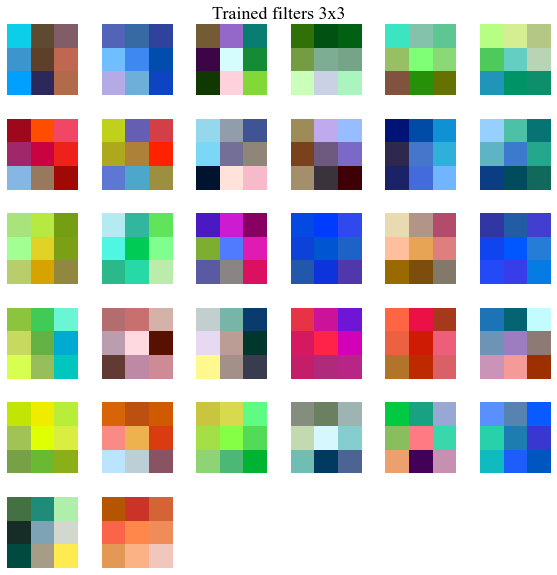

(5, 5, 3, 32)
(32, 5, 5, 3)


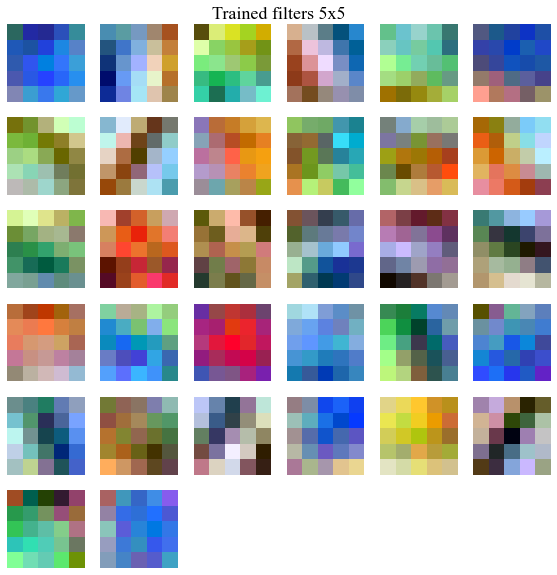

(9, 9, 3, 32)
(32, 9, 9, 3)


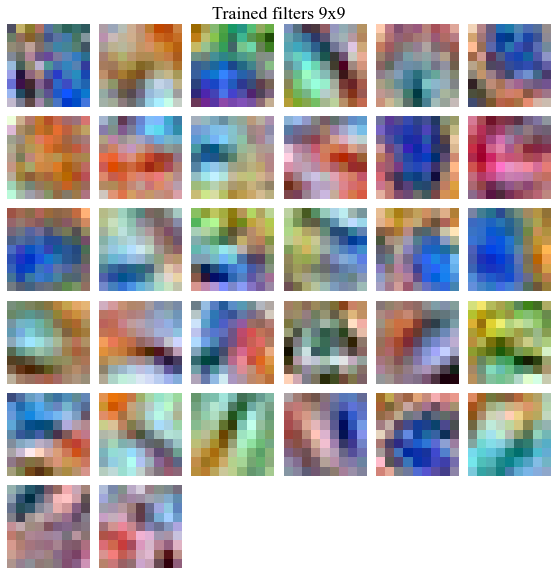

(13, 13, 3, 32)
(32, 13, 13, 3)


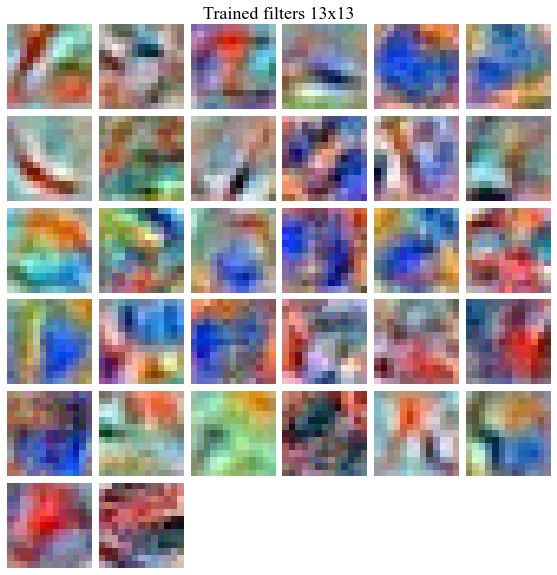

(15, 15, 3, 32)
(32, 15, 15, 3)


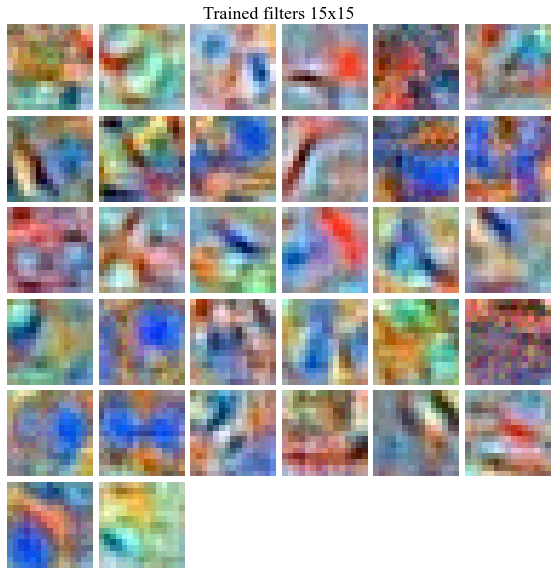

(19, 19, 3, 32)
(32, 19, 19, 3)


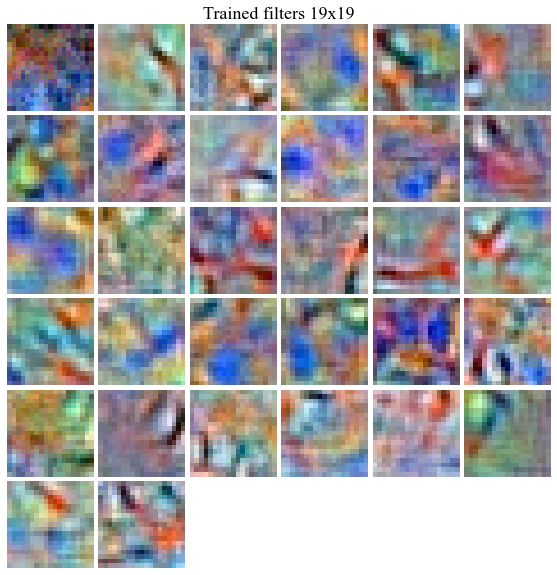

(23, 23, 3, 32)
(32, 23, 23, 3)


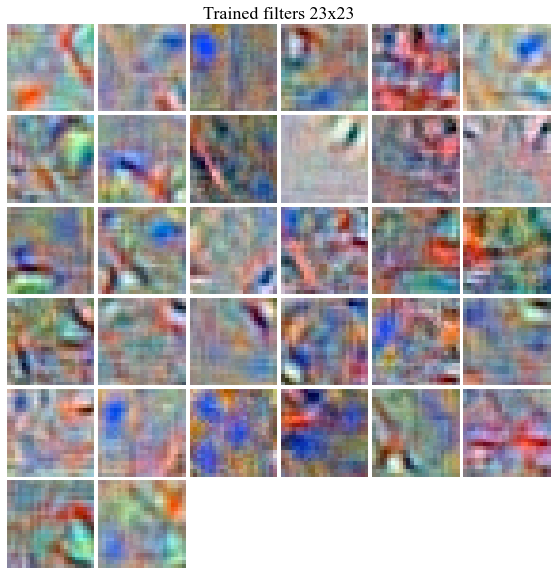

(25, 25, 3, 32)
(32, 25, 25, 3)


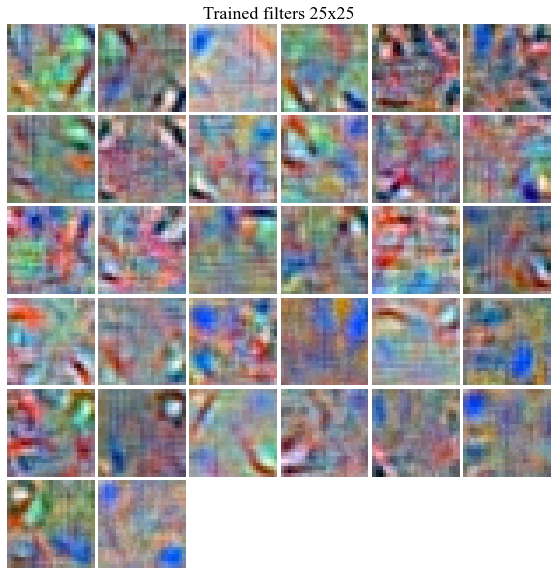

(31, 31, 3, 32)
(32, 31, 31, 3)


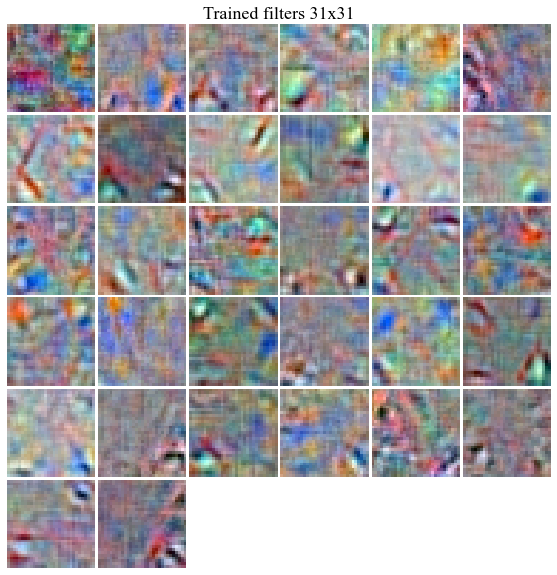

In [38]:
for i in range(len(model)):
    w = model[i].get_weights()
    print(w[0].shape)
    # print(model[i].get_config())
    # l = model[i].layers
    # print(l[0].get_weights()[0].shape)

    # Visualizing filters
    temp = w[0].transpose(3, 0, 1, 2)
    print(temp.shape)  # (81, 32, 32, 3)

    # Plotting
    fig = plt.figure()
    grid = convert_to_grid(temp)
    plt.imshow(grid.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.gcf().set_size_inches(10, 10)
    name = 'Trained filters ' + str(filters[i]) + 'x' + str(filters[i])
    plt.title(name, fontsize=18)
    
    # Showing the plot
    plt.show()

    # Saving the plot
    name = 'filters-' + str(filters[i]) + 'x' + str(filters[i]) + '.png'
    fig.savefig(name)
    plt.close()

### Predicting with one image from test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 32, 32, 3)
[3]


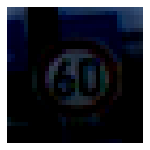

(43,)
ClassId: 3
Label: Speed limit (60km/h)


In [40]:
%matplotlib inline

# Preparing image for predicting from test dataset
x_input = data['x_test'][100:101]
print(x_input.shape)
y_input = data['y_test'][100:101]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
plt.show()

# Getting scores from forward pass of input image
scores = model[0].predict(x_input)
print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text('label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])

## Insights and key findings

**The CNN model with the kernel size 5×5 shows the 87.3% accuracy of the traffic sign classification in the test set. This shows a great potential to apply it to the sign recognision and the drivers will recieve the alert ahead of time, so that it could help reduce the occurrence of traffic accidents.**

## Next steps

**We can further explore more computer vision techniuqes and models in this work, such as YOLO v3 and RetinaNet-50, which are a state-of-the-art, real-time object detection system. These models may have better performance in real time recognision area than conventional CNN model.**